<h1 style='text-align: center;'>Survivor:</h1>
<h2 style='text-align: center;'>Exploring Contestant Trends Through Data</h2>

This projects aims to look at the long-running CBS show Survivor over the years, by examining if there are any trends present that would point to certain demographics having better chances of winning the show than others, or conversely, if certain demographics have noteably lower chances of winning. 

It also looks at how these trends vary between the classic era of Survivor (seasons 1-39), and the new era (seasons 40 onward). We'll explore the data on contestant demographics and gameplay statistics, as collected in the scraper.py script, creating visualizations to support any findings. I have also created a [Tableau dashboard](https://public.tableau.com/app/profile/camilla.babb/viz/Survivor_17399844202740/Dashboard1) as an additional visual aid for some of the queries seen in the data exploration portion of this notebook.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import functions as f

### Importing Data

In [3]:
contestants = pd.read_csv('csv_files/contestants.csv')
stats = pd.read_csv('csv_files/stats.csv')
idols = pd.read_csv('csv_files/idols.csv')
advantages = pd.read_csv('csv_files/advantages.csv')
immunities = pd.read_csv('csv_files/immunities.csv')

In [4]:
contestants.tail(3)

,Season,Name,Age,Hometown,Profession,Finish,Ethnicity,Gender,Lgbt,Has Disability,State,Country
872,48,Chrissy Sarnowsky,55,"Chicago, IL",Fire Lieutenant,0,White,F,False,False,IL,USA
873,48,Star Toomey,28,"Augusta, GA",Sales Expert,0,African-American,F,True,False,GA,USA
874,48,Mary Zheng,31,"Philadelphia, PA",Substance Abuse Counselor,0,Asian-American,F,False,False,PA,USA


### Cleaning Data

After loading the datasets in, it's time to clean the data. 
I want to take the tables for advantages, idols, and individual immunity challenges, and add them to the stats table.

To do this, I create a function that cleans these tables. This function drops unnecessary and duplicate columns, strips column names, replaces and fills values as needed, and changes the dtypes of columns to match the values. It then merges the tables together on the Contestant and Season columns, using outer join for the advantages, idols, and immunities tables so to not lose any data, and then using a left join on the stats table, filtering out any contestants not included elsewhere in the data (ie, from seasons of the Australian version of the show)

In [5]:
# Clean the advantages, idols, immunities, and stats DataFrames and merge together into stats using clean_and_merge function from functions.py
stats = f.clean_and_merge(advantages, idols, immunities, stats)
#stats.to_csv('stats.csv', index=False)
stats.head()

,Season,Contestant,Survival Score,Survival Average,Challenge Wins,Challenge Appearances,Challenge Win %,Sit Outs,Votes For Bootee,Votes Against (Total),...,Jury Votes %,Idols Found,Idols Held,Idols Played,Votes Voided,Immunity Challenge Wins,Immunity Challenge Appearances,Advantages Found,Advantages Played,Notes
0,1,Kelly Wiglesworth,1.34,12.26,5.87,16.10,0.36,2,6,0,...,0.43,0,0,0,0,4,8,0,0,NA
1,1,Richard Hatch,1.58,7.82,1.87,16.10,0.12,0,9,6,...,0.57,0,0,0,0,0,0,0,0,NA
2,1,Rudy Boesch,1.09,3.95,1.62,15.10,0.11,3,10,8,...,0.00,0,0,0,0,0,0,0,0,NA
3,1,Gretchen Cordy,1.12,3.85,1.23,3.07,0.40,0,3,4,...,0.00,0,0,0,0,0,0,0,0,NA
4,1,Susan Hawk,0.95,3.67,0.87,15.10,0.06,0,9,5,...,0.00,0,0,0,0,0,0,0,0,NA


Next, I rename all the columns in the newly merged stats table that were abbreviated to their full meanings, to improve readability. I also write the changes I've made here back to csv, so I can have a cleaned file ready for use in Tableau later.

In [6]:
# Change column names for stats table using rename_columns()
stats = f.rename_columns(stats)

stats.head(3)

,Season,Contestant,Survival Score,Survival Average,Challenge Wins,Challenge Appearances,Challenge Win %,Sit Outs,Votes For Bootee,Votes Against (Total),...,Jury Votes %,Idols Found,Idols Held,Idols Played,Votes Voided,Immunity Challenge Wins,Immunity Challenge Appearances,Advantages Found,Advantages Played,Notes
0,1,Kelly Wiglesworth,1.34,12.26,5.87,16.1,0.36,2,6,0,...,0.43,0,0,0,0,4,8,0,0,NA
1,1,Richard Hatch,1.58,7.82,1.87,16.1,0.12,0,9,6,...,0.57,0,0,0,0,0,0,0,0,NA
2,1,Rudy Boesch,1.09,3.95,1.62,15.1,0.11,3,10,8,...,0.00,0,0,0,0,0,0,0,0,NA


Checking the csv files I realized the contestant names in my stats and contestants tables didn't always match up with each other. To handle this, I create a name dictionary containing the contestant names as they appear in the contestants table, and I then apply the find_closest_match function I created in my scraper.py file to the Contestant column of the stats table. Finally, I manually replace the remaining inconsistencies in the Contestant column.

I also save the newly cleaned, merged, and updated stats DataFrame back to a .csv file, so I can work with the data in Tableau as well.

In [7]:
# create a name dictionary to contain the contestant names as they appear in the contestants dataframe
name_dict = {name: name for name in contestants['Name']}

# find closest match for names in stats, replace them with the match in contestants
stats['Contestant'] = stats['Contestant'].apply(lambda name: f.find_closest_match(name, name_dict, threshold=0.7))

# manually replace any remaining names that couldn't be handled in find_closest_match
stats['Contestant'] = stats['Contestant'].replace({'Jonny Fairplay': 'Jon Dalton',
'Daniel Dasilva': 'Wardog DaSilva', 'Papa Bear Caruso': 'Mark Caruso'})

# Save the cleaned data back to stats.csv
stats.to_csv('csv_files/stats.csv', index=False)

Next, I fill the null values in the contestants_df table, which only consists of the Finish column for the upcoming season 48, which hasn't aired yet and has no data for this column. I also convert the rest of the values in the Finish column from string to int datatypes.

In [8]:
# fill null values
contestants['Finish'] = contestants['Finish'].fillna(0)
# strip values of ending 'th'
contestants['Finish'] = contestants['Finish'].astype(str).str.strip('th')
# replace string values of placements with integer equivalents
contestants['Finish'] = contestants['Finish'].replace({
    'Winner': 1,
    'Runner-up': 2,
    'Co-runner up': 2,
    '2nd Runner-up': 2,
    '3rd': 3, 
    '1s': 1
})
# change the Finish column datatype to integer
contestants['Finish'] = contestants['Finish'].astype(int)

I create two new columns for the contestants_df table, 'State' and 'Country'. I mostly created these so that when I work with these files in Tableau, I can map the contestant geographic data. I needed both state and country values so that it would map not only how many contestants were in each state, but also map the contestants who originate from Canada.

Starting with the state column, I create a function to extract the state from the 'Hometown' column. Most of the values in the column are formatted 'City, ST', with the name of the home city, and the state abbreviation. There are two types of outliers- contestants from Washington DC, which was typically formatted without a separating comma, and contestants from Canada, whose hometowns were formatted 'City, PR (Canada)'. To handle these, I added if statements to deal with both individually, formatting them to the 'City, ST' standard. I then apply the function to create the new column.

In [9]:
# Create a new column with the extracted state/province
contestants['State'] = contestants['Hometown'].apply(f.extract_state)
contestants.head(3)

,Season,Name,Age,Hometown,Profession,Finish,Ethnicity,Gender,Lgbt,Has Disability,State,Country
0,1,Sonja Christopher,63,"Walnut Creek, CA",Gym Teacher / Retired,16,White,F,True,False,CA,USA
1,1,B.B. Andersen,64,"Mission Hills, KS",Real Estate Developer,15,White,M,False,False,KS,USA
2,1,Stacey Stillman,27,"San Francisco, CA",Attorney,14,White,F,False,False,CA,USA


To create the Country column, I create a function that checks if 'Canada' is in the contestant['Hometown'] value, and returns 'Canada' as the country if it is, and 'USA' if not. The US version of Survivor hasn't had any non-US/Canadian competitors to date, so this binary works for my needs. That function is then also applied to contestants['Hometown'] to create the column contestants['Country'].

I then save the contestants DataFrame back to .csv so I have the cleaned and updated data to work with in [Tableau](https://public.tableau.com/app/profile/camilla.babb/viz/Survivor_17399844202740/Dashboard1).

In [10]:
# Applying the add_countries function to contestants['Hometown'] column, we create a new column of contestant Countries
contestants['Country'] = contestants['Hometown'].apply(f.add_countries)
# I then write the cleaned contestants dataframe back to .csv, for use in Tableau
contestants.to_csv('csv_files/contestants.csv', index=False)
contestants.head(3)

,Season,Name,Age,Hometown,Profession,Finish,Ethnicity,Gender,Lgbt,Has Disability,State,Country
0,1,Sonja Christopher,63,"Walnut Creek, CA",Gym Teacher / Retired,16,White,F,True,False,CA,USA
1,1,B.B. Andersen,64,"Mission Hills, KS",Real Estate Developer,15,White,M,False,False,KS,USA
2,1,Stacey Stillman,27,"San Francisco, CA",Attorney,14,White,F,False,False,CA,USA


### Data Exploration and Visualizations

Starting off with the data exploration, I wanted to first do some calculatiions. Looking at the contestants table, we take a look at the column 'Age' to get a better idea of what the common ages of contestants are. Using aggregate functions, we can see that the youngest person to compete on Survivor was 18 years old, and the oldest was 75. We also see that the most commonly occuring age of contestants is 24 years old, while the average age is 33.

In [11]:
# Mean, median, mode calculations for contestant ages
avg_age = int(contestants['Age'].mean())
median_age = int(contestants['Age'].median())
most_frequent_age = int(contestants['Age'].mode()[0])
# Find the lowest and highest ages present in contestants
min_age = int(contestants['Age'].min())
max_age = int(contestants['Age'].max())

print(f"The average contestant age is {avg_age} years old. The median age is {median_age} years old, and the most common contestant age is {most_frequent_age} years old.")
print(f"The youngest contestant on Survivor was {min_age} years old, while the oldest was {max_age} years old.")

The average contestant age is 33 years old. The median age is 31 years old, and the most common contestant age is 24 years old.
The youngest contestant on Survivor was 18 years old, while the oldest was 75 years old.


Next, I wanted to look at challenge wins and how contestants as a whole perform. As a note, this value is a float, as any team challenge wins are counted as a fractional value, based on how many contestants were competing on the winning team.

The calculations show that the average number of challenge wins is 1.35, likely due to the fact that the most common number of challenge wins is 0. This makes sense, as most challenges are elimination challenges, so there is feasibly one person per season who goes home in the first episode with no wins.

In [12]:
# mean, median, mode calculations for stats dataframe
avg_ch_wins = stats['Challenge Wins'].mean()
median_ch_wins = stats['Challenge Wins'].median()
ch_wins_mode = stats['Challenge Wins'].mode()[0]
# Find the max number of challenge wins by a single contestant in one season
max_ch_wins = stats['Challenge Wins'].max()

print(f"The average number of challenge wins is {avg_ch_wins:.2f}. The median challenge wins is {median_ch_wins:.2f}, and the most common number of challenge wins is {ch_wins_mode:.2f}")
print(f"The most challenge wins in the show by one contestant is {max_ch_wins}.")

The average number of challenge wins is 1.35. The median challenge wins is 0.91, and the most common number of challenge wins is 0.00
The most challenge wins in the show by one contestant is 9.34.


Before moving on to the visualizations, I first need to set up the sql database. To do this, I convert the dataframes contestants and stats to sql, writing them to the sqlite3 database. I then create a function thats purpose is to execute sql queries, and convert the results to pandas dataframes.

In [13]:
# Set up the connection to Survivor sql database
conn = sqlite3.connect('survivor.db')

# Converts the contestants and stats dataframes to SQL tables inside the Survivor database
contestants.to_sql('contestants', conn, if_exists='replace', index=False)
stats.to_sql('stats', conn, if_exists='replace', index=False)

# Close the connection
conn.close()

def sql(query:str) -> pd.DataFrame: 
    '''
    Performs the SQL query on the Survivor database and returns the result as a DataFrame.

    Args:
    query (str): The SQL query to be executed.

Returns:
    pd.DataFrame: DataFrame containing the result of the query.
    '''
    # Set up the connection to survivor.db
    conn = sqlite3.connect('survivor.db')

    # create a dataframe equal to the result of the query
    df = pd.read_sql_query(query, conn)
    
    # close the connection
    conn.close()
    return df


Going into the visualizations, I first create a bar chart depicting the ethnicities of Survivor season winners. This shows us that the vast majority of season winners are white with 33 winners, followed by Latin American with 5.

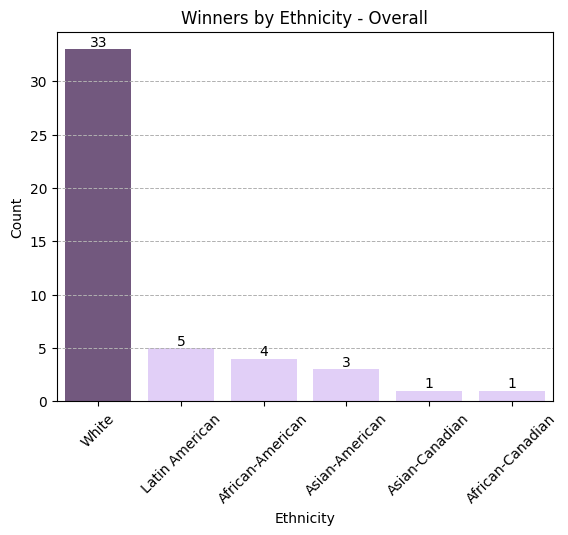

In [14]:
# Bar chart depicting ethnicities of season winners

winner_ethn_overall = '''
SELECT 
    Ethnicity, COUNT(Ethnicity) as Count
FROM 
    contestants
WHERE 
    Finish = 1
GROUP BY 
    Ethnicity
ORDER BY 
    Count DESC;
'''
sql(winner_ethn_overall)
max_count = sql(winner_ethn_overall)['Count'].max()

colors = ['#745284' if count == max_count else '#E0C9FD' for count in sql(winner_ethn_overall)['Count']]
plot = sns.barplot(x='Ethnicity',
                    y='Count',
                    data=sql(winner_ethn_overall),
                    palette=colors,
                    hue='Ethnicity',
                    legend=False,)
for bar in plot.patches:
    height = bar.get_height()
    plot.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.0f}',
        ha='center',
        va='bottom'
    )
plt.title('Winners by Ethnicity - Overall')
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
plt.tick_params(axis='x', rotation=45)
plt.show()

Expanding on this, I make two more graphs meant to examine the distribution of ethnicity in season winners. These graphs will break down the winners per season to two eras- the Classic Era (Seasons 1-39), and the New Era (Seasons 40 onward). This distinction is made due to the massive overhaul present in the show starting with season 40. This includes how diversity is handled in the contestants competing on the show starting in season 41, with an explicit push to have more [diverse casting](https://insidesurvivor.com/cbs-sets-new-diversity-goals-survivor-casts-to-now-be-50-people-of-color-47519 "CBS Diversity Goals") by CBS for multiple of their reality tv shows, in part due to criticisms of the lack of diversity prior.

In these graphs, you can see there has been an effect on the diversity of winners so far, with 2 of the 5 Latin American winners coming from the last 8 seasons alone. Though the dataset for the New Era is still much smaller compared to the Classic Era, there is a more even distribution of winners. However, there has not been a single African American winner in the New Era to date, though there has been an African Canadian winner, the first in the show overall. There has also been 1 Asian Canadian and 1 Asian American winner in the New Era thus far. 

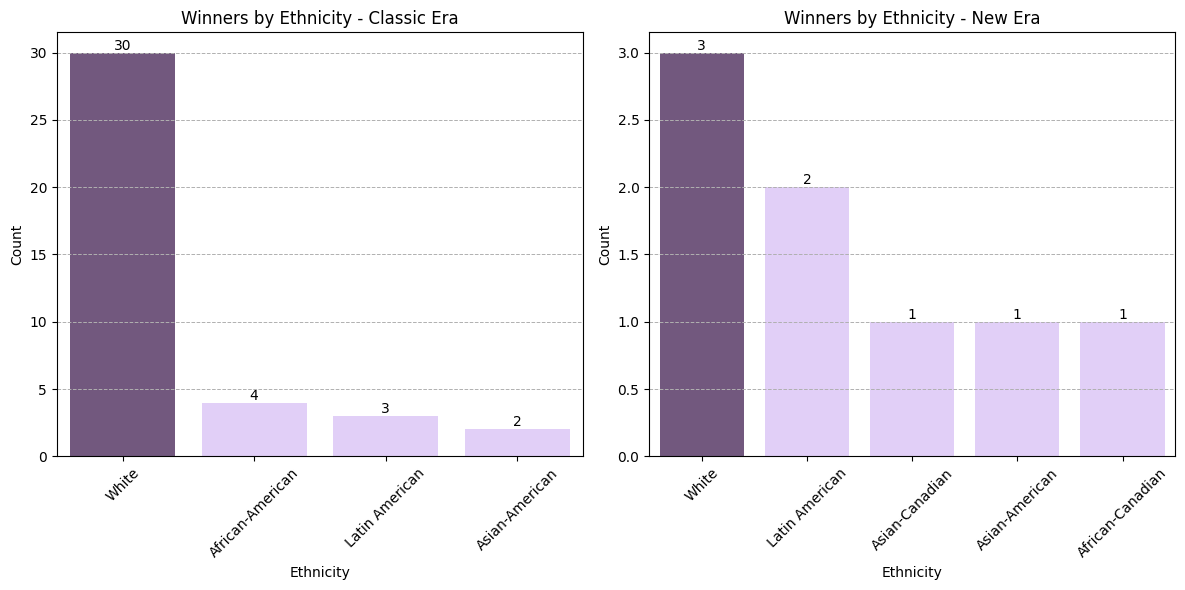

In [15]:
# Bar chart depicting ethnicities of season winners - Classic Era vs. New Era

winner_ethn_classic = '''
SELECT 
    Ethnicity, COUNT(Ethnicity) as Count
FROM 
    contestants
WHERE 
    Finish = 1 AND Season <= 39
GROUP BY 
    Ethnicity
ORDER BY 
    Count DESC;
'''
sql(winner_ethn_classic)
max_count = sql(winner_ethn_classic)['Count'].max()

winner_ethn_new_era = '''
SELECT 
    Ethnicity, COUNT(Ethnicity) as Count
FROM 
    contestants
WHERE 
    Finish = 1 AND Season >= 40
GROUP BY 
    Ethnicity 
ORDER BY 
    Count DESC;
'''
sql(winner_ethn_new_era)
max_new_count = sql(winner_ethn_new_era)['Count'].max()

colors1 = ['#745284' if count == max_count else '#E0C9FD' for count in sql(winner_ethn_classic)['Count']]
colors2 = ['#745284' if count == max_new_count else '#E0C9FD' for count in sql(winner_ethn_new_era)['Count']]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot1 = sns.barplot(x='Ethnicity',
                    y='Count',
                    data=sql(winner_ethn_classic),
                    palette=colors1,
                    hue='Ethnicity',
                    legend=False,
                    ax=axes[0])
axes[0].set_title('Winners by Ethnicity - Classic Era')
for bar in plot1.patches:
    height = bar.get_height()
    plot1.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.0f}',
        ha='center',
        va='bottom'
    )
axes[0].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
axes[0].tick_params(axis='x', rotation=45)

plot2 = sns.barplot(x='Ethnicity',
                    y='Count',
                    data=sql(winner_ethn_new_era),
                    palette=colors2,
                    hue='Ethnicity',
                    legend=False,
                    ax=axes[1])
axes[1].set_title('Winners by Ethnicity - New Era')
for bar in plot2.patches:
    height = bar.get_height()
    plot2.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.0f}',
        ha='center',
        va='bottom'
    )
axes[1].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

Let's take a step back now and look at the distribution of ethncities of contestants not just in season winners, but in the show overall. 

Here we see, just as with season winners, the overall distribution is by and large white contestants at a total of 594 contestants, not shortly followed by African American contestants with 128 total contestants over 48 seasons. This is interesting, as despite being the second most represented ethnicity in the show, African American contestants are only the third most represented ethnicity group in season winners, with just 4 winners in the show's 47 completed seasons.

Asian American and Latin American contestants have 73 and 72 contestants overall, respectively. Asian Canadians have had 5 contestants in the last 8 seasons alone, and African Canadians have had 3.

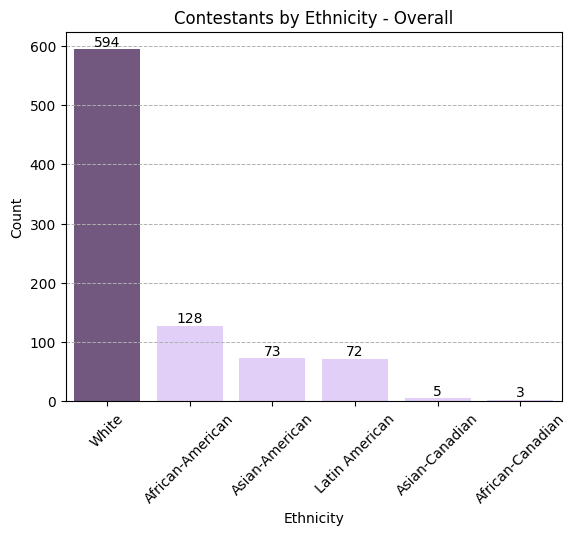

In [16]:
# Bar chart depicting contestant distributions by ethnicity

overall_ethnicity = '''
SELECT 
    Ethnicity, COUNT(Ethnicity) as Count
FROM 
    contestants
GROUP BY 
    Ethnicity
ORDER BY 
    Count DESC;
'''
sql(overall_ethnicity)
max_count = sql(overall_ethnicity)['Count'].max()

colors = ['#745284' if count == max_count else '#E0C9FD' for count in sql(overall_ethnicity)['Count']]
plot = sns.barplot(x='Ethnicity',
                    y='Count',
                    data=sql(overall_ethnicity),
                    palette=colors,
                    hue='Ethnicity',
                    legend=False,)
for bar in plot.patches:
    height = bar.get_height()
    plot.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.0f}',
        ha='center',
        va='bottom'
    )
plt.title('Contestants by Ethnicity - Overall')
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
plt.tick_params(axis='x', rotation=45)
plt.show()

Breaking this down by era, we see that white contestants make up the majority of contestants overall for both the Classic Era and the New Era, though by a much smaller margin in the New Era than Classic. African American contestants seem to make up about a quarter of the contestants overall in the New Era, making the lack of any winners present more stark, despite the lack low number of completed seasons to date.

Looking at these graphs and the winner distribution graphs, we see that the distribution of winners to contestants overall are fairly even for the Classic Era, while the New Era has more discrepencies. On top of the lack of African American winners present in the new seasons, Latin American contestants are the 4th most represented ethnicity overall in the New Era, though they have more winners than not only African American contestants, but also Asian Americans who sit at the 3rd most represented in the New Era.

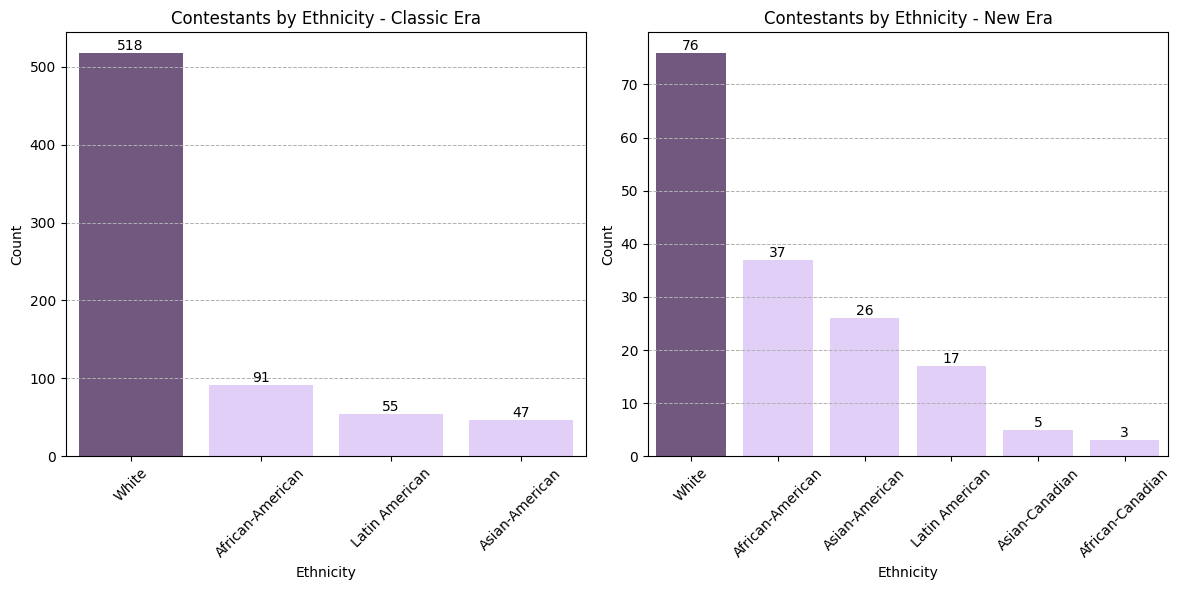

In [17]:
# Bar chart depicting contestant distributions by ethnicity - Classic Era vs. New Era

classic_era_ethnicity = '''
SELECT 
    Ethnicity, COUNT(Ethnicity) as Count
FROM 
    contestants
WHERE 
    Season <= 39
GROUP BY 
    Ethnicity
ORDER BY 
    Count DESC;
'''
sql(classic_era_ethnicity)
max_count = sql(classic_era_ethnicity)['Count'].max()

new_era_ethnicity = '''
SELECT 
    Ethnicity, COUNT(Ethnicity) as Count
FROM 
    contestants
WHERE 
    Season >= 40
GROUP BY 
    Ethnicity
ORDER BY 
    Count DESC;
'''
sql(new_era_ethnicity)
max_new_count = sql(new_era_ethnicity)['Count'].max()

colors1 = ['#745284' if count == max_count else '#E0C9FD' for count in sql(classic_era_ethnicity)['Count']]
colors2 = ['#745284' if count == max_new_count else '#E0C9FD' for count in sql(new_era_ethnicity)['Count']] # set colors

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot1 = sns.barplot(x='Ethnicity', 
                   y='Count', 
                   data=sql(classic_era_ethnicity), 
                   palette=colors1, 
                   hue='Ethnicity', 
                   legend=False,
                   ax=axes[0])
axes[0].set_title('Contestants by Ethnicity - Classic Era')
for bar in plot1.patches:
    height = bar.get_height()
    plot1.text(
        bar.get_x() + bar.get_width() / 2,  
        height,                 
        f'{height:.0f}',
        ha='center',             
        va='bottom'                       
    )
axes[0].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
axes[0].tick_params(axis='x', rotation=45)


plot2 = sns.barplot(x='Ethnicity', 
                    y='Count', 
                    data=sql(new_era_ethnicity), 
                    palette=colors2, 
                    hue='Ethnicity', 
                    legend=False, 
                    ax=axes[1])
for bar in plot2.patches:
    height = bar.get_height()
    plot2.text(
        bar.get_x() + bar.get_width() / 2,  
        height,                 
        f'{height:.0f}',
        ha='center',             
        va='bottom'                       
    )
axes[1].set_title('Contestants by Ethnicity - New Era')
axes[1].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

Next I want to examine what the average placement for the different ethnicities throughout the show are. The number of total contestants in a season varies, but most commonly there are either 18 or 20 contestants per season. 

Looking at the graph for all seasons, Asian Canadians tend to finish the highest, placing 6th overall on average, followed by African Canadians who on average finish 7th. This is a bit skewed due to there only being a handful of contestants for these ethnicities overall. White contestants and Latin American contestants both have an average finish of 9th place, which with about 18 contestants per season, seems to be expected. African American contestants have an average finish of 10th place, which is still about what one would expect the average to be, despite being a bit lower than white and Latin American contestants. Finally, Asian Americans tend to have the lowest average finish at 11th place.

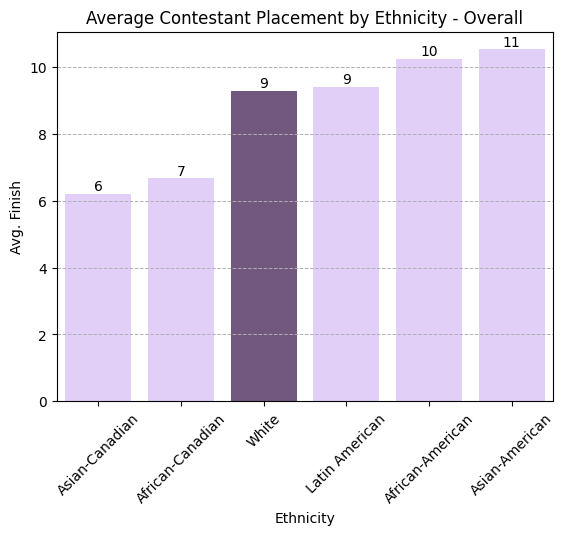

In [18]:
# Bar chart depicting the average placements of contestants by ethnicity

avg_placement_overall = '''
SELECT 
    Ethnicity, AVG(Finish) as 'Avg. Finish'
FROM 
    contestants
GROUP BY 
    Ethnicity
ORDER BY 
    AVG(Finish) ASC;
'''
sql(avg_placement_overall)

colors = ['#745284' if ethnicity == 'White' else '#E0C9FD' for ethnicity in sql(avg_placement_overall)['Ethnicity']]
plot = sns.barplot(x='Ethnicity',
                    y='Avg. Finish',
                    data=sql(avg_placement_overall),
                    palette=colors,
                    hue='Ethnicity',
                    legend=False,)
for bar in plot.patches:
    height = bar.get_height()
    plot.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.0f}',
        ha='center',
        va='bottom'
    )
plt.title('Average Contestant Placement by Ethnicity - Overall')
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
plt.tick_params(axis='x', rotation=45)
plt.show()

Breaking it down into eras again, we see white contestants have an average finish of 9th place in both eras, though in the Classic Era they had the best finish, while in the New Era African Canadian, Latin American, and Asian Canadian contestants have better placements, with averages of 7, 8, and 8 respectively. This has Latin American contestants see a 2 place improvement from the Classic Era, where they had an average finish of 10th. Both see Asian Americans  with an average finish of 11th place, though the New Era has African American contestants with an average finish of 11th as well, while they have an average finish of 10th place in the Classic Era. 

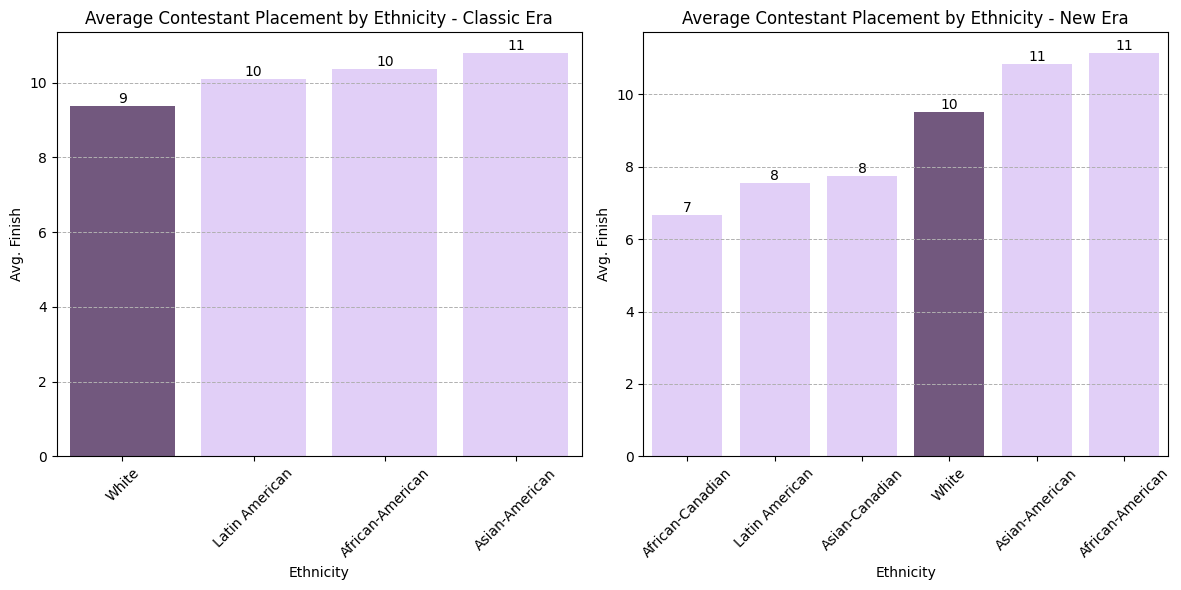

In [19]:
# Bar chart depicting the average placements of contestants by ethnicity - Classic Era vs. New Era


avg_placement_classic = '''
SELECT 
    Ethnicity, AVG(Finish) as 'Avg. Finish'
FROM 
    contestants
WHERE 
    Season <= 39
GROUP BY 
    Ethnicity
ORDER BY 
    AVG(Finish) ASC;
'''
sql(avg_placement_classic)


avg_placement_new = '''
SELECT 
    Ethnicity, AVG(Finish) as 'Avg. Finish'
FROM 
    contestants
WHERE 
    Season >= 40 AND Finish <> 0
GROUP BY 
    Ethnicity
ORDER BY 
    AVG(Finish) ASC;
'''
sql(avg_placement_new)

colors1 = ['#745284' if ethnicity == 'White' else '#E0C9FD' for ethnicity in sql(avg_placement_classic)['Ethnicity']]
colors2 = ['#745284' if ethnicity == 'White' else '#E0C9FD' for ethnicity in sql(avg_placement_new)['Ethnicity']]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot1 = sns.barplot(x='Ethnicity', 
                   y='Avg. Finish', 
                   data=sql(avg_placement_classic), 
                   palette=colors1, 
                   hue='Ethnicity', 
                   legend=False,
                   ax=axes[0])
axes[0].set_title('Average Contestant Placement by Ethnicity - Classic Era')
for bar in plot1.patches:
    height = bar.get_height()
    plot1.text(
        bar.get_x() + bar.get_width() / 2,  
        height,                 
        f'{height:.0f}',
        ha='center',             
        va='bottom'                       
    )
axes[0].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
axes[0].tick_params(axis='x', rotation=45)


plot2 = sns.barplot(x='Ethnicity', 
                    y='Avg. Finish', 
                    data=sql(avg_placement_new), 
                    palette=colors2, 
                    hue='Ethnicity', 
                    legend=False, 
                    ax=axes[1])
for bar in plot2.patches:
    height = bar.get_height()
    plot2.text(
        bar.get_x() + bar.get_width() / 2,  
        height,                 
        f'{height:.0f}',
        ha='center',             
        va='bottom'                       
    )
axes[1].set_title('Average Contestant Placement by Ethnicity - New Era')
axes[1].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

The winners of Survivor are determined by a jury of their peers. The jury size varies depending on the season, but generally any contestant eliminated from the competition after the starting tribes merge votes for who they think should win in the finals. The stats dataset has the column Jury Votes %, which determines what percent of the jury voted for a contestant present in the finals, whether or not they won in the end. I wanted to look at how this varies by ethnicity as well.

For this graph we look at the average jury vote % for the different ethnicities over the show, if the contestant was in the finale (since some of the earlier seasons only had 2 contestant in the finals, any contestant who was a runner-up in their season has a finish of 2).

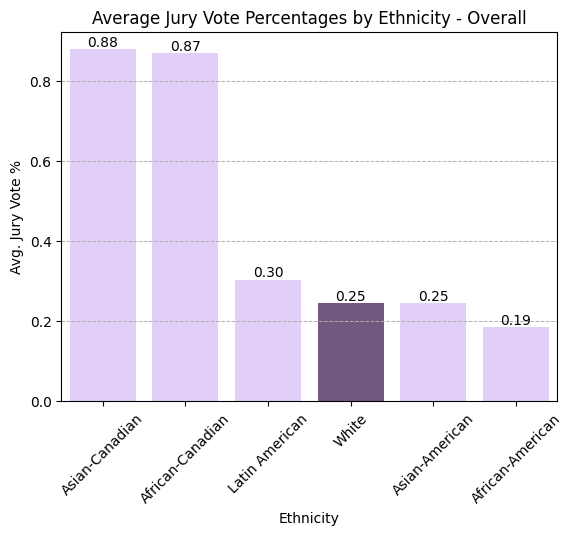

In [34]:
# Bar chart depicting average jury vote percentage by ethnicity

jury_votes_overall = '''
SELECT 
    AVG(s.'Jury Votes %') as 'Avg. Jury Vote %', c.Ethnicity
FROM 
    contestants as c
LEFT JOIN 
    stats as s ON c.Name = s.Contestant
WHERE 
    c.Finish = 1 OR c.Finish = 2
GROUP BY 
    Ethnicity
ORDER BY 
    AVG(s.'Jury Votes %') DESC;
'''
sql(jury_votes_overall)

colors = ['#745284' if ethnicity == 'White' else '#E0C9FD' for ethnicity in sql(jury_votes_overall)['Ethnicity']]


plot = sns.barplot(x='Ethnicity', 
                   y='Avg. Jury Vote %', 
                   data=sql(jury_votes_overall), 
                   palette=colors, 
                   hue='Ethnicity', 
                   legend=False,)

for bar in plot.patches:
    height = bar.get_height()
    plot.text(
        bar.get_x() + bar.get_width() / 2,  
        height,                 
        f'{height:.2f}',
        ha='center',             
        va='bottom'                       
    )
plt.title('Average Jury Vote Percentages by Ethnicity - Overall')
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
plt.tick_params(axis='x', rotation=45)
plt.show()

Looking at the Classic Era and New Era side by side, we see that white contestants only have the second highest average jury vote percentage in the Classic Era, despite making the majority of winners. This is likely due to them also making up the vast majority of contestants present on the show during these seasons, meaning a high number were likely present in the season finales as well, whether or not they won. We also see that Latin American contestants have the highest overall average jury vote percentage, which we can infer means that even if they do not win, Latin American contestants present in the finale get more votes on average. African American and Asian American contestants both receive lower average jury vote percentages than the others. 

In the New Era, Asian Canadian and African Canadian contestants have the highest average jury vote percentages by far, at 0.88 and 0.87 respectively. This is because there have only been 1 of each ethnicity present in any season finales to date, and both were the winners of their respective finales. Asian American contestants made a large leap in the New Era, now having the third highest avg. jury vote percentage at 0.43, followed by Latin American contestants with 0.35 average jury vote percentage. Interestingly, all ethnicities in the New Era have higher average vote percentages than they did in the Classic Era, except for African American contestants whose score is .06 lower than in the Classic Era. (Though not represented here, my [Tableau dashboard](https://public.tableau.com/app/profile/camilla.babb/viz/Survivor_17399844202740/Dashboard1) reveals that this is due to there only being 1 African American contestant present in any season finale thus far in the New Era)   

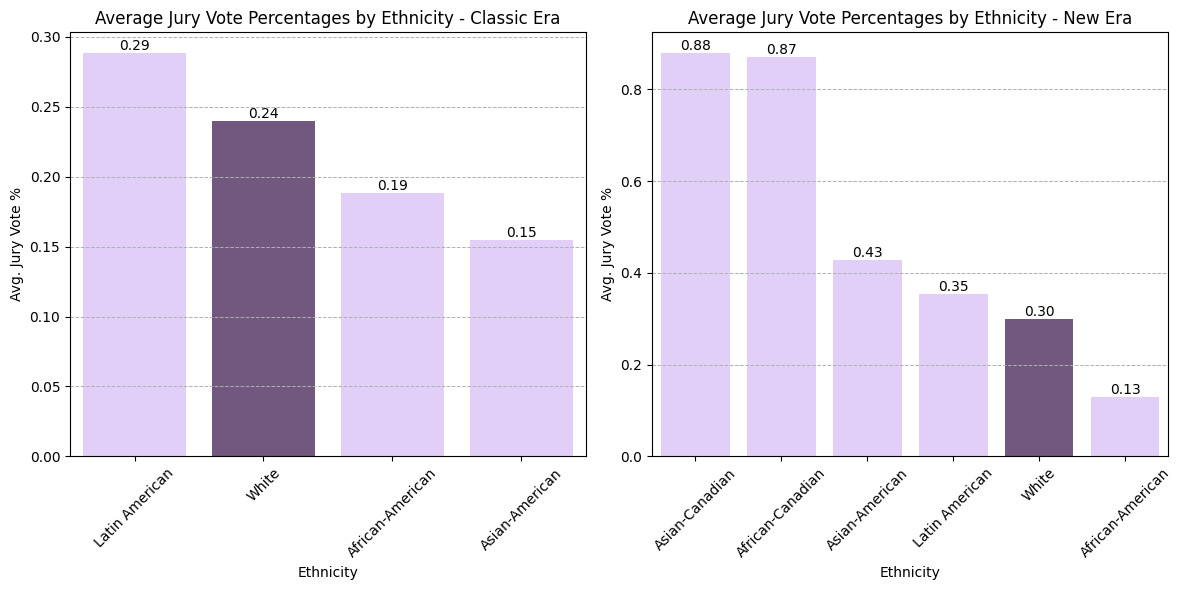

In [21]:
# Bar chart depicting average jury vote percentage by ethnicity - Classic Era vs. New Era

jury_votes_classic = '''
SELECT 
    AVG(s.'Jury Votes %') as 'Avg. Jury Vote %', c.Ethnicity
FROM 
    contestants as c
LEFT JOIN 
    stats as s ON c.Name = s.Contestant
WHERE 
    c.Season <= 39 AND (c.Finish = 1 OR c.Finish = 2)
GROUP BY 
    Ethnicity
ORDER BY 
    AVG(s.'Jury Votes %') DESC;
'''
sql(jury_votes_classic)


jury_votes_new = '''
SELECT 
    AVG(s.'Jury Votes %') as 'Avg. Jury Vote %', c.Ethnicity
FROM 
    contestants as c
LEFT JOIN 
    stats as s ON c.Name = s.Contestant
WHERE 
    c.Season >= 40 AND (c.Finish = 1 OR c.Finish = 2)
GROUP BY 
    Ethnicity
ORDER BY 
    AVG(s.'Jury Votes %') DESC;
'''
sql(jury_votes_new)

colors1 = ['#745284' if ethnicity == 'White' else '#E0C9FD' for ethnicity in sql(jury_votes_classic)['Ethnicity']]
colors2 = ['#745284' if ethnicity == 'White' else '#E0C9FD' for ethnicity in sql(jury_votes_new)['Ethnicity']]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot1 = sns.barplot(x='Ethnicity', 
                   y='Avg. Jury Vote %', 
                   data=sql(jury_votes_classic), 
                   palette=colors1, 
                   hue='Ethnicity', 
                   legend=False,
                   ax=axes[0])
axes[0].set_title('Average Jury Vote Percentages by Ethnicity - Classic Era')
for bar in plot1.patches:
    height = bar.get_height()
    plot1.text(
        bar.get_x() + bar.get_width() / 2,  
        height,                 
        f'{height:.2f}',
        ha='center',             
        va='bottom'                       
    )
axes[0].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
axes[0].tick_params(axis='x', rotation=45)


plot2 = sns.barplot(x='Ethnicity', 
                    y='Avg. Jury Vote %', 
                    data=sql(jury_votes_new), 
                    palette=colors2, 
                    hue='Ethnicity', 
                    legend=False, 
                    ax=axes[1])
for bar in plot2.patches:
    height = bar.get_height()
    plot2.text(
        bar.get_x() + bar.get_width() / 2,  
        height,                 
        f'{height:.2f}',
        ha='center',             
        va='bottom'                       
    )
axes[1].set_title('Average Jury Vote Percentages by Ethnicity - New Era')
axes[1].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

Next I do a quick SQL query to show how many contestants of each gender have been present on the show to date. We see the distribution of male and female contestants is pretty even. There has also been 2 contestants who identify as non-binary (however, neither did so on the show - though Teeny Chirichillo in season 47 did openly discuss their questioning of their gender during confessionals, making them widely accepted as the first openly non-binary contestant at the time of competing)

In [22]:
# Gender distributions

gender_sql = '''
SELECT 
    Gender,COUNT(Gender) as Count
FROM 
    contestants
GROUP BY 
    Gender
ORDER BY 
    Count;
'''
sql(gender_sql)


,Gender,Count
0,N,2
1,F,434
2,M,439


With the gender distribution overall in mind, I want to take a look at how the distribution of contestants by gender is for season winners. Looking at the season winners for the Classic Era and the New Era, we see that in the Classic Era, male contestants won a majority of the time, at 61.54% of all winners, with female contestants only winning the other 38.46%. This ratio surprisingly flips in the New Era, with female contestants currently winning 62.50% of the time, and males making up the other 37.50%. There have been no non-binary winners at this time.

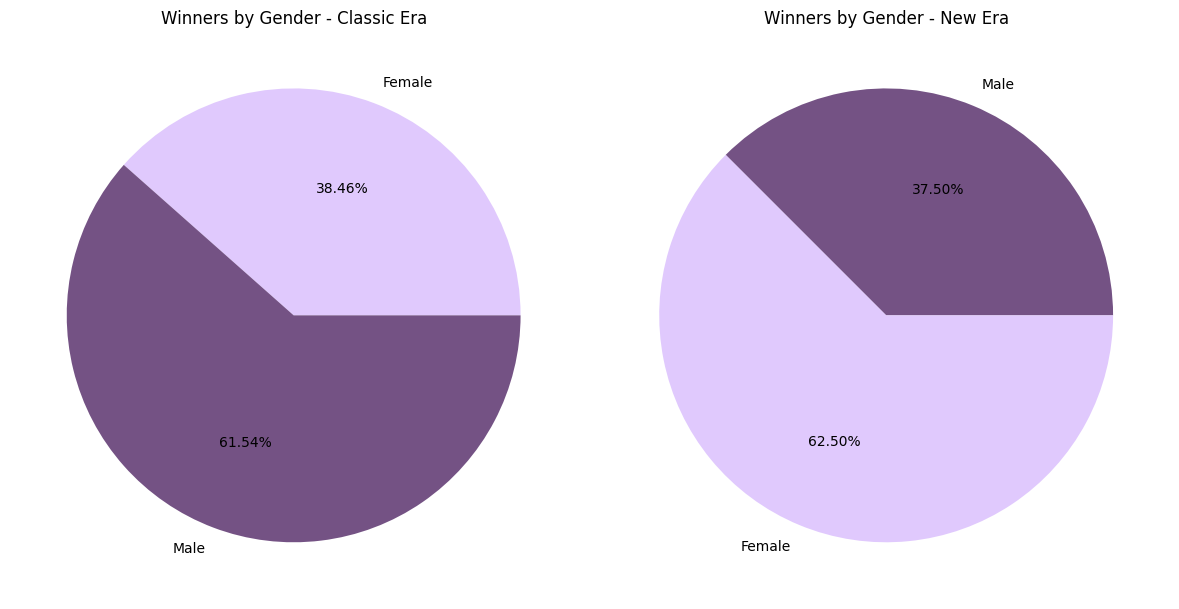

In [23]:
# Pie charts depicting distribution of winners by gender

winner_genders_classic = '''
SELECT 
    (CASE Gender
        WHEN 'F' THEN 'Female'
        WHEN 'M' THEN 'Male'
        ELSE 'Non-binary'
    END) as Gender, COUNT(Gender) as Count
FROM 
    contestants 
WHERE 
    Finish = 1 AND Season <= 39
GROUP BY 
    Gender
ORDER BY 
    Count;
'''
sql(winner_genders_classic)
max_count = sql(winner_genders_classic)['Count'].max()

winner_genders_new = '''
SELECT 
    (CASE Gender
        WHEN 'F' THEN 'Female'
        WHEN 'M' THEN 'Male'
        ELSE 'Non-binary'
    END) as Gender, COUNT(Gender) as Count
FROM 
    contestants 
WHERE 
    Finish = 1 AND Season >= 40
GROUP BY 
    Gender
ORDER BY 
    Count;
'''
sql(winner_genders_new)
max_count_new = sql(winner_genders_new)['Count'].max()

colors1 = ['#745284' if gender == 'Male' else '#E0C9FD' for gender in sql(winner_genders_classic)['Gender']]
colors2 = ['#745284' if gender == 'Male' else '#E0C9FD' for gender in sql(winner_genders_new)['Gender']]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(sql(winner_genders_classic)['Count'], colors = colors1, labels=sql(winner_genders_classic)['Gender'], autopct='%.2f%%')
axes[0].set_title('Winners by Gender - Classic Era')

axes[1].pie(sql(winner_genders_new)['Count'], colors = colors2, labels=sql(winner_genders_new)['Gender'], autopct='%.2f%%')
axes[1].set_title('Winners by Gender - New Era')

plt.tight_layout()
plt.show()

Next I want to look at how different age groups place on average, and what the trend for the different age group's placements vary over time. To visualize this, I first use CASE in my SQL query to define the age groups '18-35', '36-55', and '56+'. I then use a for loop to graph each of these age groups on the same graph.

We see a pretty even trend for 18-35 and 36-55 year olds, both hanging around 10th place on average throughout, and tend to have peaks and falls the correlate. 56+ year olds have a much more sporatic and widely varying line, with contestants seeming to place either very highly or very low. This is largely in part to the lack of representation this age group has in the show overall. Many seasons don't have any contestants 56 years old or older, and the seasons that do tend to only have 1 or 2. 

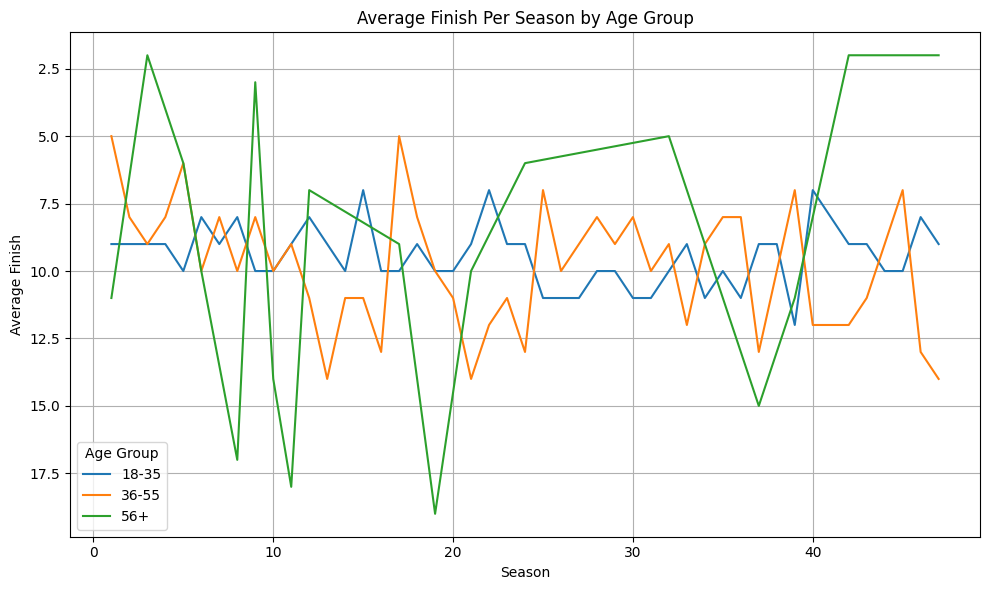

In [24]:
# Multi-line chart depicting average placements of age groups over the seasons

avg_placement_age = '''
SELECT 
    (CASE 
        WHEN Age BETWEEN 18 AND 35 THEN '18-35'
        WHEN Age BETWEEN 36 AND 55 THEN '36-55'
        ELSE '56+'
    END) as 'Age Group', Season, ROUND(AVG(Finish), 0) as 'Avg. Finish'
FROM 
    contestants
WHERE 
    Finish <> 0 AND Season <> 48 
GROUP BY 
    Season, (CASE 
            WHEN Age BETWEEN 18 AND 35 THEN '18-35'
            WHEN Age BETWEEN 36 AND 55 THEN '36-55'
            ELSE '56+'
            END)
ORDER BY 
    Season, 'Age Group';
'''

age_placement = sql(avg_placement_age)  
age_placement = age_placement.pivot(index='Season', columns='Age Group', values='Avg. Finish')
age_placement = age_placement.interpolate(method='linear')

plt.figure(figsize=(10, 6))
for age_group in age_placement.columns:
    plt.plot(age_placement.index, age_placement[age_group], label=age_group)
plt.title('Average Finish Per Season by Age Group')
plt.xlabel('Season')
plt.ylabel('Average Finish')
plt.legend(title='Age Group')

plt.grid(True)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Another demographic I was interested in looking at was contestants with disabilities. Including the current season which has not yet completed, there have only been 15 contestants to date with known disabilities during their time on the show. I wanted to take a look at how these contestants placed, and found that no contestant with a known disability, in the New Era or overall, has finished in their season with a placement higher than 5th. This means no contestants with disabilities have made it to their season's finale.

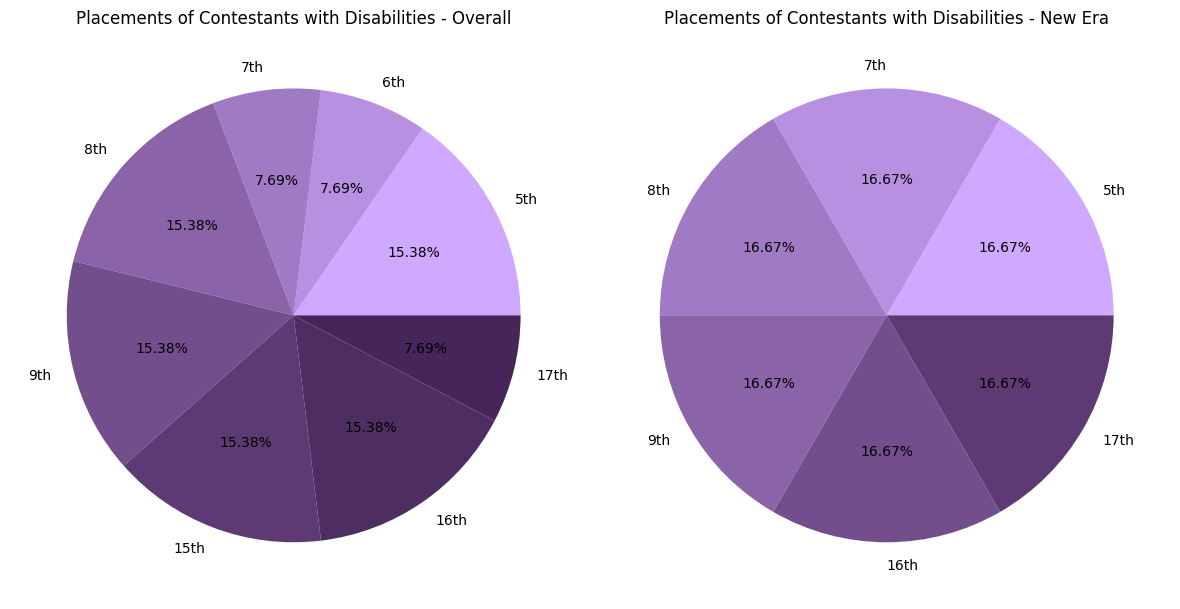

In [25]:
# Pie charts depicting the placements of contestants with disabilities

disability_placement = '''
SELECT 
    (CASE 
        WHEN c.Finish = 1 THEN '1st'
        WHEN c.Finish = 2 THEN '2nd'
        WHEN c.Finish = 3 THEN '3rd'
        ELSE CAST(c.Finish AS TEXT) || 'th' END) as Finish, COUNT(s.Contestant) as Count 
FROM 
    contestants as c
LEFT JOIN 
    stats as s ON c.Name = s.Contestant
WHERE 
    c.'Has Disability' = True AND Finish <> 0
GROUP BY 
    c.Finish
ORDER BY    
    c.Finish, Count;
''' 
sql(disability_placement)

disability_placement_new = '''
SELECT  
    (CASE 
        WHEN c.Finish = 1 THEN '1st'
        WHEN c.Finish = 2 THEN '2nd'
        WHEN c.Finish = 3 THEN '3rd'
        ELSE CAST(c.Finish AS TEXT) || 'th' END) as Finish, COUNT(s.Contestant) as Count 
FROM 
    contestants as c
LEFT JOIN 
    stats as s ON c.Name = s.Contestant
WHERE 
    c.'Has Disability' = True AND c.Finish <> 0 AND c.Season >= 40
GROUP BY 
    c.Finish
ORDER BY 
    c.Finish, Count;
''' 
sql(disability_placement_new)

colors = ['#CFA8FF', '#B890E1', '#A07AC4', '#8A63A8', '#734E8D', '#5D3A73', '#4E2D62', '#46265A']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(sql(disability_placement)['Count'], colors = colors, labels=sql(disability_placement)['Finish'], autopct='%.2f%%')
axes[0].set_title('Placements of Contestants with Disabilities - Overall')

axes[1].pie(sql(disability_placement_new)['Count'], colors = colors, labels=sql(disability_placement_new)['Finish'], autopct='%.2f%%')
axes[1].set_title('Placements of Contestants with Disabilities - New Era')

plt.tight_layout()
plt.show()

I was curious as to what the geographic distribution of season winners looked like. In my [Tableau dashboard](https://public.tableau.com/app/profile/camilla.babb/viz/Survivor_17399844202740/Dashboard1) I actually have created maps to visualize this distribution, but was running into issues here getting the map to work and didn't have enough time to work it out. I opted to still have this data represent here despite the issues, so I used a horizontal bar graph. Overall, California is called home by 8 season winners, making it the state with the most winners overall. 

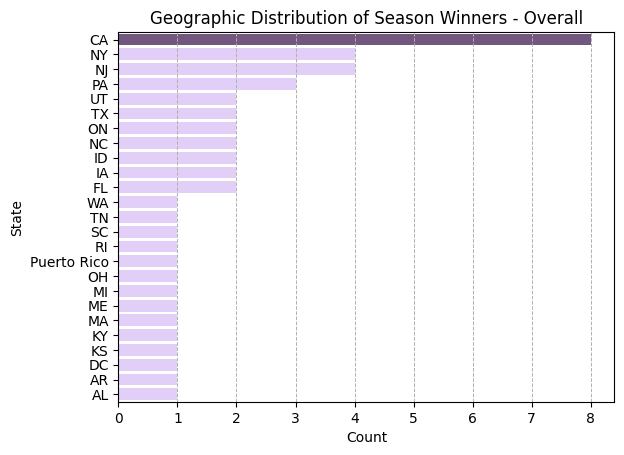

In [26]:
# Horizontal bar chart depicting geographic distribution of season winners

location = '''
SELECT 
    State, COUNT(State) as Count
FROM 
    contestants
WHERE 
    Finish = 1
GROUP BY 
    State
ORDER BY 
    Count DESC;
'''
sql(location)
max_count = sql(location)['Count'].max()

colors = {count: '#745284' if count == max_count else '#E0C9FD' for count in sql(location)['Count']}
plot = sns.barplot(x='Count',
                    y='State',
                    data=sql(location),
                    palette=colors,
                    hue='Count',
                    legend=False,
                    orient='h')
plt.title('Geographic Distribution of Season Winners - Overall')
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.7)
plt.show()

Next, I did another qucik SQL query to look at the professions that have won a season of Survivor the most times. I found that Police Officers have the most wins, with 3 total contestants winning the show overall. This is followed by Salon Owners, Office Assistants, and Firefighters with 2 wins each. Looking into this a bit further with my [Tableau dashboard](https://public.tableau.com/app/profile/camilla.babb/viz/Survivor_17399844202740/Dashboard1), we see that Salon Owners are actually the highest winning profession in the New Era, with both wins occuring in those seasons. 

It's worth noting that the professions as listed may not be consolidated with their values - Lawyer, Attorney, Public Defender are all similar professions, but distinctly different values that are present in the dataset.

In [27]:
# Professions - Count of professions most likely to win

profession_count = '''
SELECT
    Profession, COUNT(Profession) as Count
FROM 
    contestants
WHERE
    Finish = 1
GROUP BY 
    Profession
HAVING
    Count > 1
ORDER BY
    Count DESC;
'''
sql(profession_count)

,Profession,Count
0,Police Officer,3
1,Salon Owner,2
2,Office Assistant,2
3,Firefighter,2


Continuing to look at professions of contestants, I wanted to look at which professions had the most individual immunity challenge wins. This graph shows that Firefighter, Pilot, Waiter, Oil Driller, Auto Customizer, and Attorney/Retired NFL Player are the professions of contestants with the tied highest number of individual immunity challenge wins. Many of these professions are physically demanding, which makes sense as challenges in the show tend to also be physically demanding. 

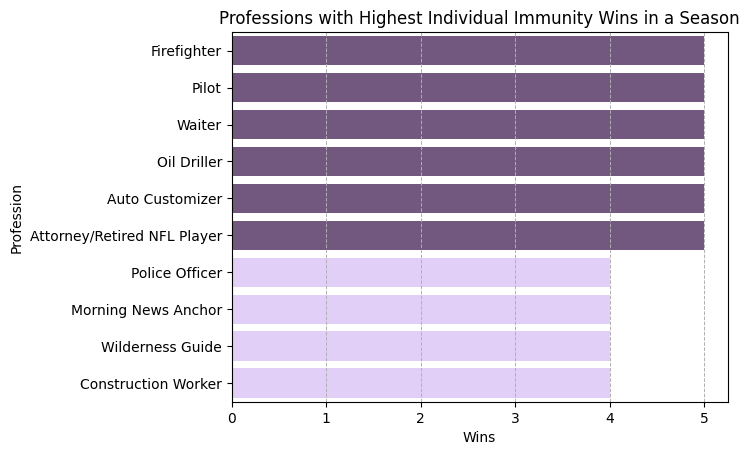

In [28]:
# Horizontal bar chart depicting professions of contestants with the highest individual immunity challenge wins

challenge_wins_professions = '''
SELECT
    c.Profession, MAX(s.'Immunity Challenge Wins') as Wins
FROM
    contestants as c
LEFT JOIN
    stats as s ON c.Name = s.Contestant
WHERE 
    c.Season <> 48 
GROUP BY
    c.Name
ORDER BY
    MAX(s.'Immunity Challenge Wins') DESC
LIMIT 10;
'''
sql(challenge_wins_professions)
max_count = sql(challenge_wins_professions)['Wins'].max()

colors = {count: '#745284' if count == max_count else '#E0C9FD' for count in sql(challenge_wins_professions)['Wins']}
plot = sns.barplot(x='Wins',
                    y='Profession',
                    data=sql(challenge_wins_professions),
                    palette=colors,
                    hue='Wins',
                    legend=False,
                    orient='h')
plt.title('Professions with Highest Individual Immunity Wins in a Season')
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.7)
plt.show()

Lastly, I wanted to see how many idols found throughout the show were found by male contestants vs female contestants. The pie chart below shows the male contestants find a majority of the idols, with 72.46% of idols found, while female contestants only found 27.54% of idols found.

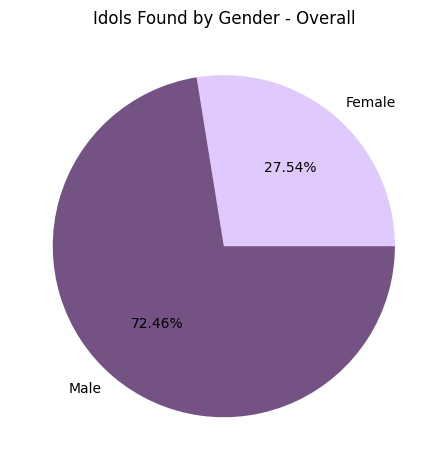

In [29]:
# Pie chart depicting distribution of idols found by gender

most_idols_gender = '''
SELECT
    (CASE c.Gender
        WHEN 'F' THEN 'Female'
        WHEN 'M' THEN 'Male' 
        ELSE 'Non-binary'
        END) as Gender, SUM(s.'Idols Found') as 'Total Idols Found'
FROM contestants as c
LEFT JOIN stats as s ON c.Name = s.Contestant
GROUP BY c.Gender
HAVING SUM(s.'Idols Found') <> 0
ORDER BY SUM(s.'Idols Found');
'''
sql(most_idols_gender)
colors = ['#745284' if gender == 'Male' else '#E0C9FD' for gender in sql(most_idols_gender)['Gender']]

fig, ax = plt.subplots()

ax.pie(sql(most_idols_gender)['Total Idols Found'], colors = colors, labels=sql(most_idols_gender)['Gender'], autopct='%.2f%%')
ax.set_title('Idols Found by Gender - Overall')


plt.tight_layout()
plt.show()

### Findings

Summarizing the data exploration, I made the following findings:
* White contestants make up the vast majority of both season winners, and contestants overall. This is seen to be the truth for both the Classic Era and New Era, though the margins are much smaller in the New Era.
* Though white contestants have more winners in the New Era than any other ethnicity, they make up less than half of the winners in the New Era overall.
* Latin American contestants, as well as Asian Canadian and African Canadian contestants in the New Era, have better odds of placing higher in the competition.
* Latin American contestants are seen to have better odds of getting jury votes when they make it to the finale, even if they do not win.
* Despite being the second highest represented ethnicity, African American contestants are under-represented as season winners in the Classic Era, and have yet to win at all in the New Era, having only had one African American contestant even making it to the finales.
* If looking at the contestants by race instead of ethnicity, there has only been one Black winner in the New Era overall, making them still the least represented race in season winners.
* While male contestants are more likely to win in the Classic Era, the New Era so far sees female contestants being more likely to win, at about the same percent the males were in the Classic Era.
* Contestants 56 years and older are under-represented as contestants as whole.
* There have been no contestants with known disabilities to win, or even make it into their season's finale, in the show's 47 completed seasons.
* Most season winners from one state were 8 total winners from California. As seen in my [Tableau Dashboard](https://public.tableau.com/app/profile/camilla.babb/viz/Survivor_17399844202740/Dashboard1), there have been no winners from California in the New Era as of yet, however there have been 2 from Ontario, Canada, and 1 from Puerto Rico, showing an attempt to diversify where contestants are picked from seems to be in play.
* Contestants with more public-facing and socially demanding jobs seem to be frequently present in season winners

### Conclusions

While there is currently a limited number of completed seasons in the New Era, we can still get a glimpse into how the changes in season 40 on affect the game as a whole, and points toward a shift in trends over who can earn the title of Sole Survivor.

In the Classic Era white contestants were more likely by far than any other ethnicity to win, partially due to white contestants making up the vast majority of contestants competing on the show. Male contestants were also more likely than female contestants to win, despite having a pretty even split between the two.

The New Era however sees a shift with its few completed seasons. Though the largest percent of season winners by ethnicities still goes to white contestants, they make up just under half of the winners so far. Likewise, female contestants now have the majority of wins. While I can't confidently say whether these trends will hold - only time will tell - it paints a picture that the New Era of Survivor's push for more diversity in casting has created tangible results as far as chances for Latin American, Asian American, Asian Canadian, and African Canadian contestants to win. That being said, while African American contestants make up nearly a quarter of participants in the New Era overall, the lack of winners and there only being one contestant so far to make it to their season finale, is hard not to notice. This may be circumstantial to the low number of completed seasons in the New Era, but I feel it's worth noting and keeping an eye on as more seasons come out.

Another noteworthy discovery was the fact that contestants with known disabilities, have not made it past 5th place to date. Typically, the final 4 is the final hurdle contestants have to face before making it to the finale, with newer seasons having no more votes after the final 5, as the 3rd spot in the final 3 is decided by having 2 contestants compete to make fire. With this in mind, it seems like contestants may intentionally get disabled contestants out while they can, as someone with more hardships to overcome is seen as a bigger threat. This is not substantiated, as I think one of the contestants who made it to 5th kept his disability a secret, but there have been disabled contestants that were voted to be eliminated with their threat level listed as a reason.

Ultimately, while these observations do provide a look into evolving dynamics, the current limited number of seasons within the New Era means there's potential for future seasons to change the trends seen here as more seasons come out. 


### Further Recommendations

There is still plenty to explore with this dataset, such as breaking down trends in gameplay as seen in the different demographics, as well as looking further into how certain gameplay stats correlate to contestants placement within their seasons. Additionally if possible, I think it would be very insightful to find data on contestant gameplay _styles_, to see how player strategy and meta game shifts effect what type of players win current day, as opposed to previous seasons. (I personally have a theory that the newer seasons are leaning towards favoring social gameplay that emphasizes honesty and sincerity over manipulation/"playing" others)

I also think it would be interesting to compare the demographics of season contestants with US Census data, to get insight into how the contestant demographics stack up.